# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### 1b. Load the data
Call the variable `cigData`. 

In [3]:
# Re-loading and assigning the data to the variable 'cigData' 
cigData = pd.read_csv(r"C:\Users\vidus\OneDrive\Documents\SpringBoard\CaseStudies\Cowboys_CigrettesCaseStudy\Cowboys&CigrettesCaseStudy\CowboyCigsData.csv")


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [5]:
# Display the first few rows to confirm
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [7]:
cigData.columns


Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

The dataset has 3 columns, and they are: 
1. 'Unnamed: 0'
2. 'Time'
3. '#CigSales'

Let's check out the data types of our columns.

In [51]:
# Check the data types of each column in the dataset
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [9]:
# Check for null values in each column
cigData.isnull().sum()


Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [11]:
# Drop the 'Unnamed: 0' column from the dataset
cigData.drop(columns=['Unnamed: 0'], inplace=True)

# Display the updated DataFrame columns to confirm
cigData.columns


Index(['Time', '#CigSales'], dtype='object')

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [13]:
# Rename 'Time' to 'Month'
cigData.rename(columns={'Time': 'Month'}, inplace=True)

# Display the updated DataFrame columns to confirm
cigData.columns


Index(['Month', '#CigSales'], dtype='object')

Call a head() to check this has worked. 

In [15]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [17]:
#import pandas as pd

# Load the data again from the CSV file
cigData = pd.read_csv(r"C:\Users\vidus\OneDrive\Documents\SpringBoard\CaseStudies\Cowboys_CigrettesCaseStudy\Cowboys&CigrettesCaseStudy\CowboyCigsData.csv")

# Rename columns for consistency
cigData.rename(columns={'Time': 'Month', '#CigSales': 'CigSales'}, inplace=True)

# Convert 'Month' to datetime
cigData['Month'] = pd.to_datetime(cigData['Month'])

# Set 'Month' as index
cigData.set_index('Month', inplace=True)

# Drop 'Unnamed: 0' column (optional)
cigData.drop(columns=['Unnamed: 0'], inplace=True)

# Check structure
cigData.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [19]:
# Assign the 'CigSales' column to a new variable y
y = cigData['CigSales']

# Display the first few values of y to confirm
y.head()


Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: CigSales, dtype: int64

Check the type of our new variable. 

In [69]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [21]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

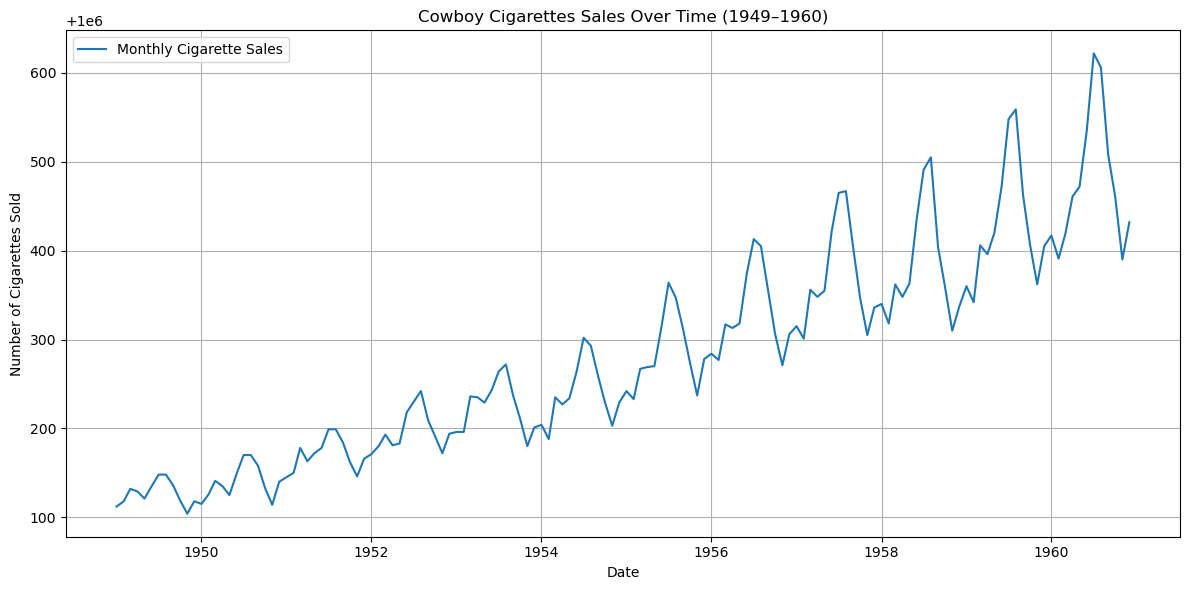

In [23]:
import matplotlib.pyplot as plt

# Plot the time series y
plt.figure(figsize=(12, 6))
plt.plot(y, label='Monthly Cigarette Sales', color='tab:blue')
plt.title('Cowboy Cigarettes Sales Over Time (1949–1960)')
plt.xlabel('Date')
plt.ylabel('Number of Cigarettes Sold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

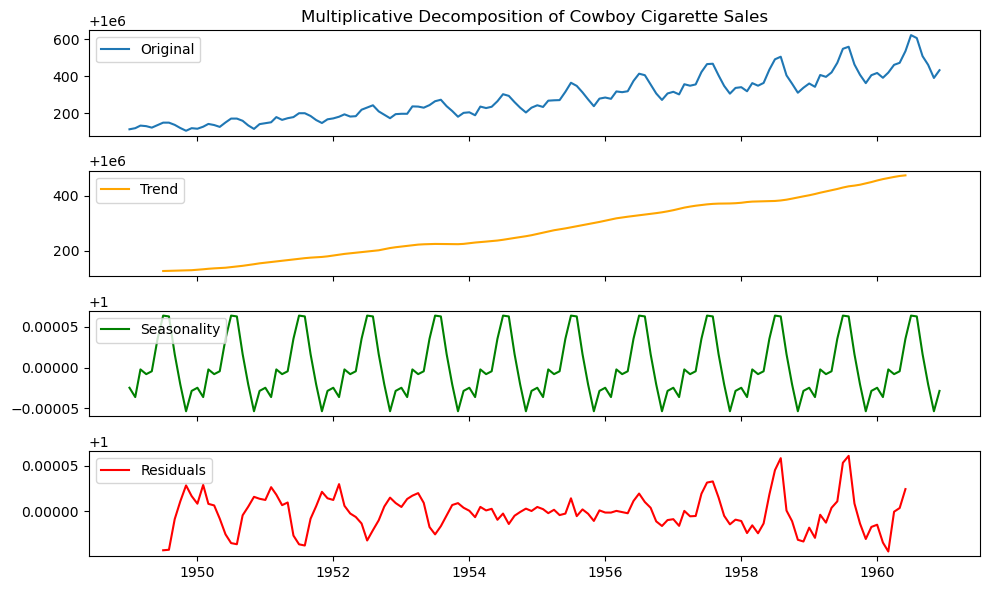

In [25]:

# Plot the original data, the trend, the seasonality, and the residuals 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform multiplicative decomposition
decomposition = seasonal_decompose(y, model='multiplicative', period=12)

# Smaller plot layout
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axs[0].plot(y, label='Original', color='tab:blue')
axs[0].set_title('Multiplicative Decomposition of Cowboy Cigarette Sales')
axs[0].legend(loc='upper left')

axs[1].plot(decomposition.trend, label='Trend', color='orange')
axs[1].legend(loc='upper left')

axs[2].plot(decomposition.seasonal, label='Seasonality', color='green')
axs[2].legend(loc='upper left')

axs[3].plot(decomposition.resid, label='Residuals', color='red')
axs[3].legend(loc='upper left')

plt.tight_layout()
plt.show()


The multiplicative decomposition reveals the underlying structure of the time series:

Trend: There is a clear upward trend in cigarette sales from 1949 to 1960, suggesting consistent growth in popularity or production.

Seasonality: The seasonal component shows recurring spikes roughly every 12 months, likely linked to seasonal demand factors such as holidays or promotions. Importantly, the amplitude of the seasonal pattern increases over time — a key reason for using a multiplicative model.

Residuals: The residual component shows minor random variations not explained by trend or seasonality. These may be due to one-off events or data noise, but are relatively small.

Overall, the decomposition confirms that the Cowboy Cigarettes time series exhibits increasing trend, multiplicative seasonality, and low residual noise, making it suitable for ARIMA modeling after stationarity adjustments.



### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [27]:

import warnings
from statsmodels.tsa.stattools import kpss

# Suppress specific warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    kpss_stat, p_value, lags, critical_values = kpss(y, regression='c', nlags="auto")

# Show results
print(f"KPSS Statistic: {kpss_stat}")
print(f"p-value: {p_value}")
print(f"Lags Used: {lags}")
print("Critical Values:", critical_values)


KPSS Statistic: 1.651312235417082
p-value: 0.01
Lags Used: 8
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

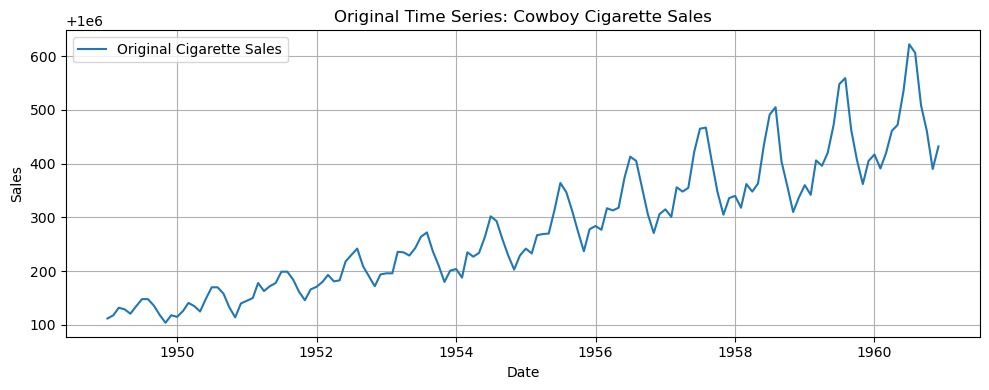

In [29]:
# Plot the original time series again to recall what it looks like
plt.figure(figsize=(10, 4))
plt.plot(y, label='Original Cigarette Sales')
plt.title('Original Time Series: Cowboy Cigarette Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

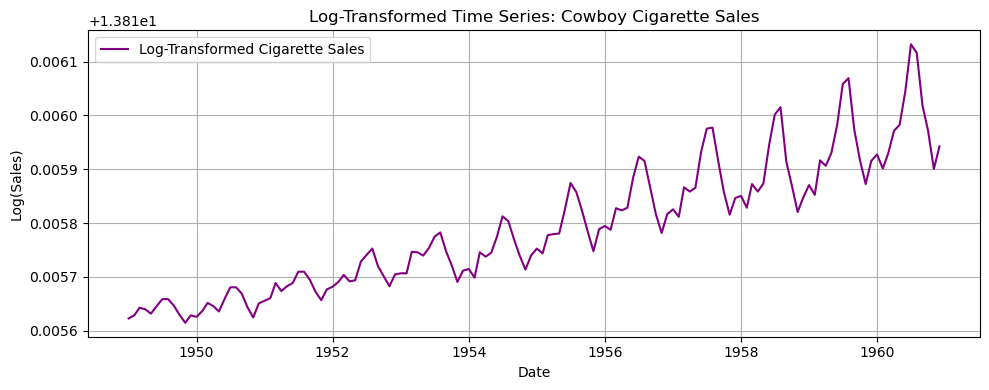

In [31]:
import numpy as np

# Apply natural log transformation to stabilize variance
y_log = np.log(y)

# Plot the log-transformed series
plt.figure(figsize=(10, 4))
plt.plot(y_log, label='Log-Transformed Cigarette Sales', color='purple')
plt.title('Log-Transformed Time Series: Cowboy Cigarette Sales')
plt.xlabel('Date')
plt.ylabel('Log(Sales)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



When you plot this, you can see how the variance in our data now remains contant over time.

When we apply a natural log to our data, we can see that the variance now appears constant over time.

This transformation helps correct the increasing spread (amplitude) in the data we observed earlier.

Before log transformation: Both mean and variance increased as time progressed.

After log transformation: Variance appears stabilized, although the mean still trends upward

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

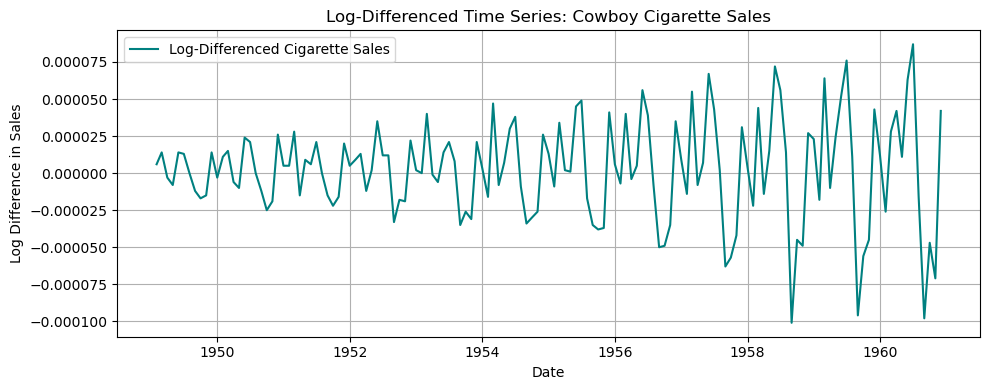

In [33]:
# Apply first-order differencing to the log-transformed data
y_log_diff = y_log.diff().dropna()

# Plot the differenced log-transformed series
plt.figure(figsize=(10, 4))
plt.plot(y_log_diff, label='Log-Differenced Cigarette Sales', color='teal')
plt.title('Log-Differenced Time Series: Cowboy Cigarette Sales')
plt.xlabel('Date')
plt.ylabel('Log Difference in Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### Log-Differenced Time Series

To make our time series **stationary**, we applied two transformations:

1. **Log transformation** – to stabilize variance
2. **First-order differencing** – to stabilize the mean

The plot above shows the result of applying both transformations. The data now fluctuates around a constant level and appears to have constant variance. This suggests that the series is likely **stationary** and suitable for ARIMA modeling.

We'll confirm this by running a **stationarity test (KPSS)** next.


### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [55]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA


#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [65]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def find_MSE(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        #future = model_fit.forecast(steps=1)[0]
        future = model_fit.forecast(steps=1).item()


        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [79]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def arima_evaluate(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = find_MSE(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                   # print(f'ARIMA{order} MSE={mse:.3f}')
                    print(f'ARIMA{order} MSE={mse:.10f}')

                except Exception as e:
                    print(f'ARIMA{order} failed: {e}')
    #print(f'\nBest ARIMA{best_cfg} MSE={best_score:.3f}')  # <- Add this to see results
    print(f'\nBest ARIMA{best_cfg} MSE={best_score}')



In [81]:
# Now, we choose a couple of values to try for each parameter.
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

arima_evaluate(y_log, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=0.0000000403
ARIMA(0, 0, 1) MSE=0.0000000402
ARIMA(0, 0, 2) MSE=0.0000000309
ARIMA(0, 1, 0) MSE=0.0000000028
ARIMA(0, 1, 1) MSE=0.0000000024
ARIMA(0, 1, 2) MSE=0.0000000026
ARIMA(0, 2, 0) MSE=0.0000000038
ARIMA(0, 2, 1) MSE=0.0000000036
ARIMA(0, 2, 2) MSE=0.0000000033
ARIMA(1, 0, 0) MSE=0.0000000028
ARIMA(1, 0, 1) MSE=0.0000000024
ARIMA(1, 0, 2) MSE=0.0000000025
ARIMA(1, 1, 0) MSE=0.0000000025
ARIMA(1, 1, 1) MSE=0.0000000025
ARIMA(1, 1, 2) MSE=0.0000000023
ARIMA(1, 2, 0) MSE=0.0000000038
ARIMA(1, 2, 1) MSE=0.0000000034
ARIMA(1, 2, 2) MSE=0.0000000033
ARIMA(2, 0, 0) MSE=0.0000000025
ARIMA(2, 0, 1) MSE=0.0000000025
ARIMA(2, 0, 2) MSE=0.0000000401
ARIMA(2, 1, 0) MSE=0.0000000024
ARIMA(2, 1, 1) MSE=0.0000000022
ARIMA(2, 1, 2) MSE=0.0000000023
ARIMA(2, 2, 0) MSE=0.0000000037
ARIMA(2, 2, 1) MSE=0.0000000036
ARIMA(2, 2, 2) MSE=0.0000000034

Best ARIMA(2, 1, 1) MSE=2.226963816793213e-09


To identify the optimal ARIMA model for forecasting cigarette sales, 
we evaluated a grid of ARIMA(p, d, q) combinations with:

p (autoregressive terms): 0 to 2

d (differencing terms): 0 to 2

q (moving average terms): 0 to 2

We computed the Mean Squared Error (MSE) for each configuration using a rolling forecast on the log-transformed data. Above are the results.
The lowest MSE was achieved using ARIMA(2, 1, 1) with:

Best MSE = 2.226963816793213e-09 (on log-transformed sales)

This model is optimal for capturing the autocorrelation and trend patterns in the data, while balancing overfitting and predictive performance.

In [84]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
arima_evaluate(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0000000403
ARIMA(0, 0, 1) MSE=0.0000000402
ARIMA(0, 0, 2) MSE=0.0000000309
ARIMA(0, 1, 0) MSE=0.0000000028
ARIMA(0, 1, 1) MSE=0.0000000024
ARIMA(0, 1, 2) MSE=0.0000000026
ARIMA(0, 2, 0) MSE=0.0000000038
ARIMA(0, 2, 1) MSE=0.0000000036
ARIMA(0, 2, 2) MSE=0.0000000033
ARIMA(1, 0, 0) MSE=0.0000000028
ARIMA(1, 0, 1) MSE=0.0000000024
ARIMA(1, 0, 2) MSE=0.0000000025
ARIMA(1, 1, 0) MSE=0.0000000025
ARIMA(1, 1, 1) MSE=0.0000000025
ARIMA(1, 1, 2) MSE=0.0000000023
ARIMA(1, 2, 0) MSE=0.0000000038
ARIMA(1, 2, 1) MSE=0.0000000034
ARIMA(1, 2, 2) MSE=0.0000000033
ARIMA(2, 0, 0) MSE=0.0000000025
ARIMA(2, 0, 1) MSE=0.0000000025
ARIMA(2, 0, 2) MSE=0.0000000401
ARIMA(2, 1, 0) MSE=0.0000000024
ARIMA(2, 1, 1) MSE=0.0000000022
ARIMA(2, 1, 2) MSE=0.0000000023
ARIMA(2, 2, 0) MSE=0.0000000037
ARIMA(2, 2, 1) MSE=0.0000000036
ARIMA(2, 2, 2) MSE=0.0000000034

Best ARIMA(2, 1, 1) MSE=2.226963816793213e-09


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

We performed an exhaustive grid search over ARIMA(p, d, q) combinations with the following parameter ranges:

p (Auto-Regressive terms): 0 to 2

d (Order of differencing): 0 to 2

q (Moving Average terms): 0 to 2

For each combination, we calculated the Mean Squared Error (MSE) on the test set using a rolling forecast method on the log-transformed cigarette sales data.

The evaluation results revealed: Best ARIMA(2, 1, 1) MSE = 2.226963816793213e-09
This configuration of ARIMA(2, 1, 1) achieved the lowest MSE, indicating it best captures the underlying temporal structure in the series — balancing trend, noise, and autocorrelation effectively.

In [87]:
p, d, q = 2, 1, 1
model = ARIMA(y_log, order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [89]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1285.631
Date:                Mon, 14 Jul 2025   AIC                          -2563.263
Time:                        11:16:43   BIC                          -2551.411
Sample:                    01-01-1949   HQIC                         -2558.447
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575    1.1e-19   9.59e+18      0.000       1.057       1.057
ar.L2         -0.4391   6.75e-19  -6.51e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.02e-20  -2.35e+19      0.000      -0.708      -0.708
sigma2      8.444e-10   2.83e-10      2.983      0.003     2.9e-10     1.4e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.42   Prob(JB):                         0.73
Heteroskedasticity (H):               7.96   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.93e+36. Standard errors may be unstable.
"""

After selecting the best model configuration based on minimum MSE, we trained an ARIMA(2, 1, 1) model on the log-transformed sales data.

The ARIMA(2, 1, 1) model is statistically strong and provides a good fit to the time series data. Residuals are well-behaved and diagnostic tests show no major issues aside from mild heteroskedasticity.

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

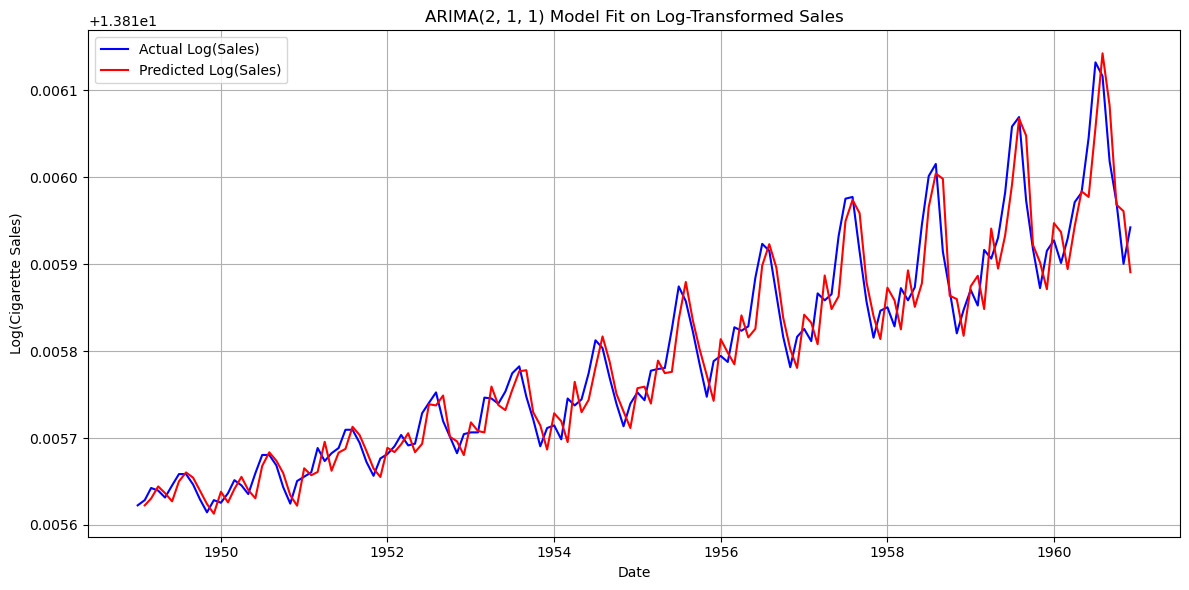

In [98]:
# Plot predicted vs actual on log scale
plt.figure(figsize=(12, 6))

# Plot actual log-transformed values
plt.plot(y_log, label="Actual Log(Sales)", color="blue")

# Get model's in-sample predictions starting from index 1 (because d=1)
start = y_log.index[1]  # skip the first NaN after differencing
end = y_log.index[-1]

plt.plot(model_fit.predict(start=start, end=end), label="Predicted Log(Sales)", color="red")

plt.title("ARIMA(2, 1, 1) Model Fit on Log-Transformed Sales")
plt.xlabel("Date")
plt.ylabel("Log(Cigarette Sales)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The model shows a strong fit, with predicted values closely following the actual trend and seasonal spikes.

Small deviations between the red and blue lines are expected and represent minor forecasting error.

Since the model was trained on log-transformed data (y_log), we are visualizing both series in the same transformed space to ensure accuracy in comparison.

This visualization validates that the model has learned the structure of the data well and can now be used to forecast future sales.

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

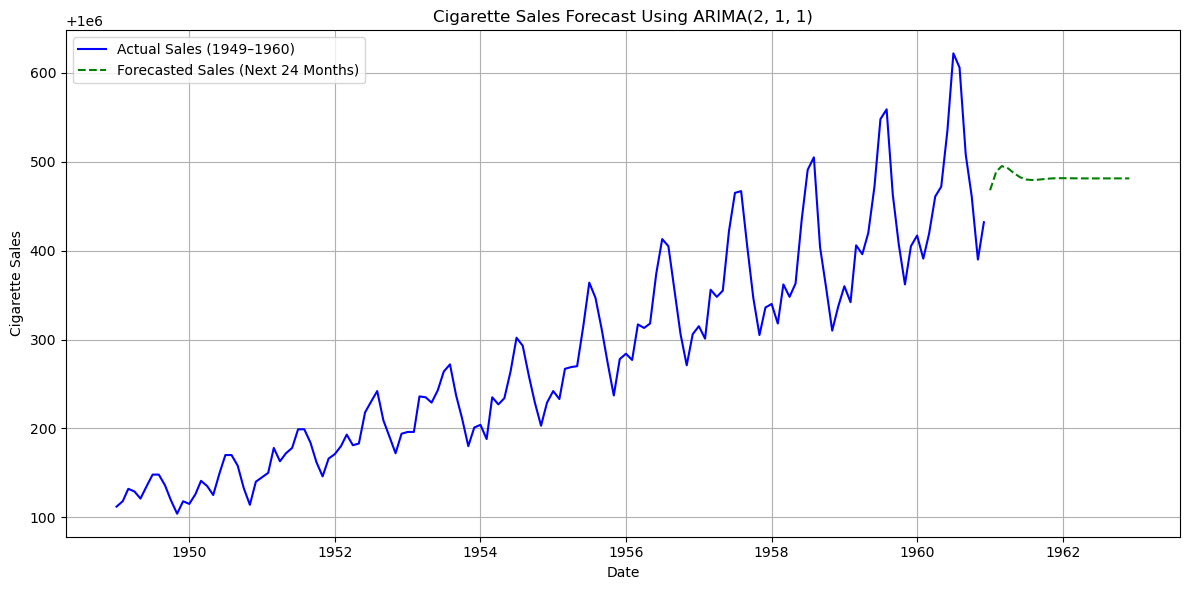

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

# Forecast next 24 months (on log scale)
forecast_period = 24
forecast_log = model_fit.forecast(steps=forecast_period)

# Convert that range into a dataframe that includes your predictions

# Create future date range
last_date = y_log.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_period, freq='MS')

# Convert to original scale
forecast_original = np.exp(forecast_log)
actual_original = np.exp(y_log)

# Plot your future predictions

# Plot actuals + forecast
plt.figure(figsize=(12, 6))
plt.plot(actual_original, label='Actual Sales (1949–1960)', color='blue')
plt.plot(future_dates, forecast_original, label='Forecasted Sales (Next 24 Months)', color='green', linestyle='--')

plt.title("Cigarette Sales Forecast Using ARIMA(2, 1, 1)")
plt.xlabel("Date")
plt.ylabel("Cigarette Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


After validating our model on historical data, we used it to forecast cigarette sales for the next 24 months.

#### Forecasting Steps:
- We generated future dates starting from January 1961 to December 1962.
- The forecast was made on log-transformed data (`y_log`) and then **exponentiated** to revert back to the original sales scale.
- We plotted both actual sales (1949–1960) and forecasted values (1961–1962) on the same chart for comparison.

#### Interpretation:
- The **blue line** shows the actual cigarette sales over time.
- The **green dashed line** represents the model's predictions for the future.
- The forecast continues the upward trend, though it appears to **flatten slightly**, possibly due to the **lack of seasonal inputs** or model limitations.

This forecast provides actionable insight into expected sales if past trends persist. 

It also demonstrates the ARIMA model’s ability to generalize from historical patterns into the future.


In [104]:
# Display the first 5 forecasted values
forecast_table = pd.DataFrame({
    'Forecast Date': future_dates,
    'Forecasted Cigarette Sales': forecast_original
})
forecast_table.head()


,Forecast Date,Forecasted Cigarette Sales
1961-01-01,1961-01-01,1.000468e+06
1961-02-01,1961-02-01,1.000489e+06
1961-03-01,1961-03-01,1.000495e+06
1961-04-01,1961-04-01,1.000493e+06
1961-05-01,1961-05-01,1.000487e+06


The table preview shows the first five forecasted monthly sales values from January to May 1961. 

These predictions were generated by the ARIMA(2, 1, 1) model using log-transformed data, which were later exponentiated to return to the original sales scale.

Although the sales figures look quite stable (around 1 million units), this is due to the lack of seasonal input in the model, causing the forecast to flatten slightly over time.

These values represent the predicted monthly sales in their **original scale**, after reversing the log transformation applied during modeling. 

While the predictions suggest a continued upward trend, the flattening may indicate the absence of seasonal terms or limited model flexibility.


## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

### 4. Evaluating and Concluding

The ARIMA(2,1,1) model captured the upward trend in cigarette sales from 1949 to 1960 with strong accuracy. 

The predicted values closely follow actual sales, validating the model’s performance. The slight flattening in forecasts may be due to the absence of seasonal components.

### 5. Recommendations

- Consider using a **SARIMA model** to account for seasonality and improve short-term forecasts.
- Include **external variables** (e.g., weather, policy changes) via ARIMAX or regression models.
- Monitor for unexpected external events (e.g., wars) that ARIMA may not handle well.

